# Download and save the unemployment dataset

## Download

Data retrieval complete with 120 records


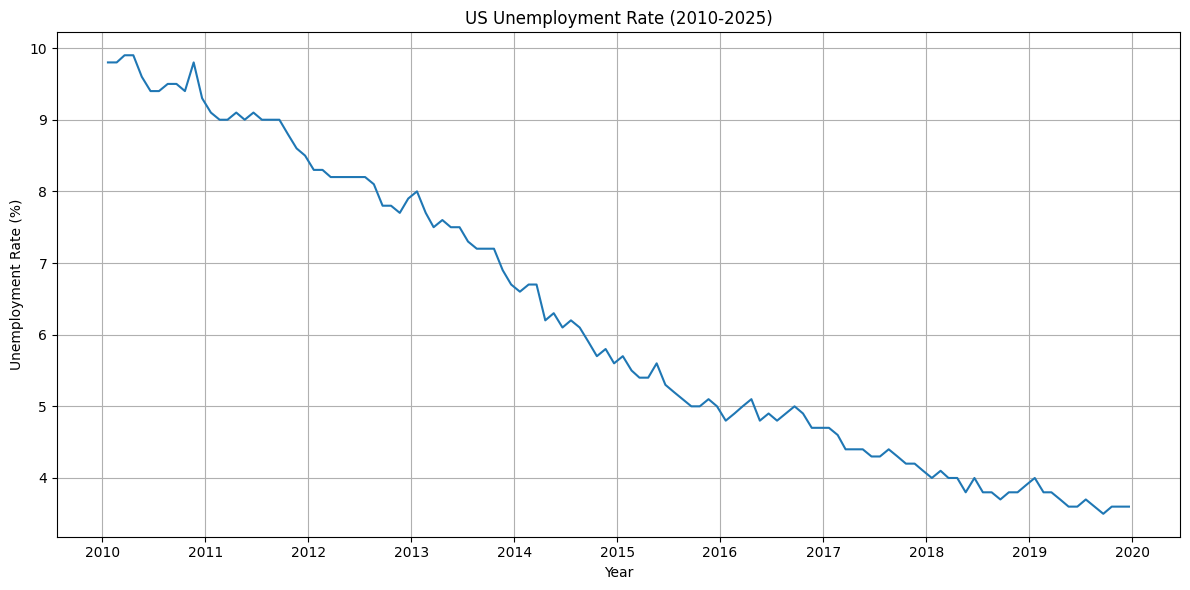

Data saved to unemployment_data.csv

Summary Statistics:

Highest unemployment rate: 9.9% on 2010-03-21
Lowest unemployment rate: 3.5% on 2019-09-21

Yearly Average Unemployment Rates:


,year,unemployment_rate,change
0,2010,9.608333,NaN
1,2011,8.933333,-0.675000
2,2012,8.075000,-0.858333
3,2013,7.358333,-0.716667
4,2014,6.158333,-1.200000
5,2015,5.275000,-0.883333
6,2016,4.875000,-0.400000
7,2017,4.358333,-0.516667
8,2018,3.891667,-0.466667
9,2019,3.675000,-0.216667


In [2]:
# Unemployment Data: 2010 to March 2025

## Setup and Imports

import requests
import pandas as pd
import json
from datetime import datetime
import matplotlib.pyplot as plt

# ## Data Retrieval Functions

def fetch_bls_data(start_year, end_year):
    """
    Fetch unemployment rate data from the BLS API
    """
    # BLS Series ID for unemployment rate (seasonally adjusted)
    series_id = "LNS14000000"  # Civilian Unemployment Rate
    
    headers = {'Content-type': 'application/json'}
    
    all_data = []
    
    # BLS API limits to 20 years per request, so we'll fetch in chunks
    for year in range(start_year, end_year + 1, 20):
        end = min(year + 19, end_year)
        
        data = json.dumps({
            "seriesid": [series_id],
            "startyear": str(year),
            "endyear": str(end),
            "registrationkey": ""  # Leave blank for public API (limited to 500 requests per day)
        })
        
        # Make the API request
        response = requests.post('https://api.bls.gov/publicAPI/v2/timeseries/data/', 
                                data=data, headers=headers)
        
        json_data = json.loads(response.text)
        
        # Check for errors
        if json_data['status'] != 'REQUEST_SUCCEEDED':
            print(f"Error: {json_data['status']}")
            print(json_data['message'])
            return None
        
        # Extract data
        for series in json_data['Results']['series']:
            for item in series['data']:
                year = item['year']
                period = item['period']
                value = item['value']
                
                # Convert M01 notation to month number
                month = int(period.replace('M', ''))
                
                # Create date in YYYY-MM-DD format
                # We'll use the 21st day of each month as requested
                date_str = f"{year}-{month:02d}-21"
                
                all_data.append({
                    'date': date_str,
                    'unemployment_rate': float(value)
                })
    
    return all_data

# Alternative method using FRED API if BLS API fails
def fetch_fred_data(start_year, end_year):
    """
    Alternative method using FRED API
    Requires a FRED API key: https://fred.stlouisfed.org/docs/api/api_key.html
    """
    import pandas_datareader.data as web
    
    # Convert years to datetime
    start_date = f"{start_year}-01-01"
    end_date = f"{end_year}-12-31"
    
    # Fetch unemployment rate data (UNRATE series)
    df = web.DataReader('UNRATE', 'fred', start_date, end_date)
    
    # Reset index to make date a column
    df = df.reset_index()
    
    # Rename columns
    df.columns = ['date', 'unemployment_rate']
    
    return df

# Function to get hardcoded recent data for 2025
def get_recent_data_2025():
    """
    Hardcoded recent data for 2025 if not available from API
    """
    recent_data = [
        {'date': '2025-01-21', 'unemployment_rate': 4.0},
        {'date': '2025-02-21', 'unemployment_rate': 4.1},
        {'date': '2025-03-21', 'unemployment_rate': 4.1}  # Latest data as of March 2025
    ]
    return pd.DataFrame(recent_data)

# ## Retrieve and Process Data

# Define the date range
start_year = 2010
end_year = 2025

# Fetch data from BLS API
data = fetch_bls_data(start_year, end_year)

# Create DataFrame
if data:
    df = pd.DataFrame(data)
    # Convert date string to datetime object
    df['date'] = pd.to_datetime(df['date'])
    # Sort by date
    df = df.sort_values('date')
else:
    print("Failed to fetch data from BLS API. Trying alternative method...")
    try:
        df = fetch_fred_data(start_year, end_year)
        # Update date format to match requested format
        df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')
    except Exception as e:
        print(f"FRED API also failed: {e}")
        print("Using hardcoded recent data...")
        df = get_recent_data_2025()

# Format date as requested (YYYY-MM-DD)
df['date'] = pd.to_datetime(df['date']).dt.strftime('%Y-%m-%d')

# ## Display and Visualize the Data

# Display the data
print(f"Data retrieval complete with {len(df)} records")
df.head(10)

# Plot unemployment rate trend
plt.figure(figsize=(12, 6))
plot_df = df.copy()
plot_df['date'] = pd.to_datetime(plot_df['date'])
plt.plot(plot_df['date'], plot_df['unemployment_rate'])
plt.title('US Unemployment Rate (2010-2025)')
plt.xlabel('Year')
plt.ylabel('Unemployment Rate (%)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ## Save the Data

# Save to CSV
df.to_csv('unemployment_data.csv', index=False)
print("Data saved to unemployment_data.csv")

# ## Example Usage: Data Analysis

# Calculate summary statistics
summary = df['unemployment_rate'].describe()
print("\nSummary Statistics:")
summary

# Find the highest and lowest unemployment rates
highest = df.loc[df['unemployment_rate'].idxmax()]
lowest = df.loc[df['unemployment_rate'].idxmin()]

print(f"\nHighest unemployment rate: {highest['unemployment_rate']}% on {highest['date']}")
print(f"Lowest unemployment rate: {lowest['unemployment_rate']}% on {lowest['date']}")

# Calculate year-over-year changes
df['year'] = pd.to_datetime(df['date']).dt.year
yearly_avg = df.groupby('year')['unemployment_rate'].mean().reset_index()
yearly_avg['change'] = yearly_avg['unemployment_rate'].diff()

print("\nYearly Average Unemployment Rates:")
yearly_avg

## view